## **Cloud Cover Recurrence Tool**

**Authors:** Bruno Rech, Jahdy Moreno Oliveira, Vinícius Lima Guimarães

This tool was developed in the course of [Introduction to Programming for Remote Sensing](https://prog-geo.github.io/index.html).

With this algorithm, we aimed at providing a quick analysis of cloud cover to any given brazilian municipality or other regions of interest, based on the Sentinel-2 collection from Brazil Data Cube. 

* * *

#### **Installation and import of required libraries**

Import the libraries that are necessary to the algorithm operation. Make sure that all libraries are installed in your Python environment. 

The following libraries were employed (with versions indicated):
- `gdal 3.8.5`
- `geopandas 0.14.4`
- `matplotlib 3.8.4`
- `numpy 1.26.4`
- `pandas 2.2.2`
- `pystac_client 0.7.7`

In [18]:
# Import libraries
import pystac_client
import pandas as pd
import geopandas as gpd
from osgeo import gdal
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import time

gdal.UseExceptions()

print('Libraries loaded successfuly')

Libraries loaded successfuly


#### **Brazil Data Cube (BDC) connection**

Connect to BDC database to access the imagery.

In [19]:
# Connect to BDC database
try:

  bdc_db = pystac_client.Client.open('https://data.inpe.br/bdc/stac/v1/')

  print('BDC database is connected')

except:

  print('ERROR: connection with BDC database failed')

BDC database is connected


#### **Region of interest (ROI) definition**

Please inform whether you want to perform the analysis over a brazilian municipality (`mu`) or provide a vector layer with your region of interest (ROI), i.e., a user-defined region (`ud`).

Note that, when working with municipalities, you may inform the state acronym (e.g., `SP`); the municipality name is case sensitive and may follow IBGE standards (e.g., `São José dos Campos`).

Please be careful when working with a user-defined ROI. Provide the path and remember that large areas may take a long processing time or may not be processed at all.

In [27]:
# Enter ROI type
roi_type = input('ROI type (mu: municipality, ud: user defined): ')

# Upload municipality shapefile
if roi_type == 'mu':

    # Indicate state
    uf_name = input('State acronym (SC, SP, MS, ...): ').upper()

    # Shapefile URL (based on state to improve computation)
    cities_url = f'https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/UFs/{uf_name}/{uf_name}_Municipios_2022.zip'

    # Load the shapefile
    try:

        print('Loading municipalities...')
        
        mun = gpd.read_file(f'zip+{cities_url}')

    except:

        raise Exception('The state acronym is invalid')

    # Municipality name
    roi_name = input('Municipality name: ')

    # Filter municipality
    roi = mun[mun['NM_MUN'] == roi_name].reset_index(drop=True)

    # If no municipality was selected
    if len(roi) == 0:

        raise Exception('Invalid municipality')

    else:

        print('Region of interest loaded successfuly\n')

        # Properties to print
        info_label = ['Municipality', 'Code', 'State', 'Area (km²)']
        properties = ['NM_MUN', 'CD_MUN', 'SIGLA_UF', 'AREA_KM2']

        # Iterate to print
        for label, info in zip(info_label, properties):

            print(f'{label + (12 - len(label)) * "."}: {roi[info][0]}')

# For when the user provides the ROI
elif roi_type == 'ud':

    # Read ROI path
    roi_path = input('ROI path: ')

    # Read ROI name (to be printed)
    roi_name = input('ROI name (to be printed): ')

    try:

        # Upload file
        roi = gpd.read_file(roi_path).to_crs(epsg='4674')

    except:

        raise Exception('The path is not valid')

    # Verify data
    if len(roi) == 0:

        raise Exception('Empty file')

    elif len(roi) > 1:

        raise Exception('The file has multiple features')

    else:

        print(f'\nRegion of interest loaded successfuly')

# When ROI type is neither 'mu' nor 'ud'
else:

    raise Exception('Invalid type')

# Get bounding box
roi_bbox = roi.bounds.transpose()[0].tolist()

# Save shapefile
roi.to_file('roi.shp')

ROI type (mu: municipality, ud: user defined):  ud
ROI path:  billings.gpkg
ROI name (to be printed):  Billings Reservoir



Region of interest loaded successfuly


#### **Period of interest**

Please inform the start and end dates for the analysis. If the period is long enough, you can indicate whether you want a monthly analysis to be performed. Case negative, only an overall analysis will be performed; case positive, you will be asked if an overall analysis should also be developed.

Be careful with period selection. Currently (May 2024), Sentinel-2 data at BDC is available from 2022 on. Furthermore, long periods may take long processing times.

In [28]:
# Collection name: Sentinel 2, Level 2A
coll_name = 'S2_L2A-1'

# Start
start = input('Start date (yyyy-mm-dd): ')

# End
end = input('End date (yyyy-mm-dd): ')

# Transform in datetime format
dt_start = pd.to_datetime(start)
dt_end = pd.to_datetime(end)

# Number of days
ndays = (dt_end - dt_start).days

# Indicate whether a monthly analysis will be performed
monthly = 'n'

# Evaluate dates
if dt_start > dt_end:

    raise Exception('The period is invalid')

else:

    # If a period of at least two months is provided
    if ndays >= 58:

        # Ask if a monthly analysis should be performed
        monthly = input('Perform monthly analysis (y [n])? ')

        if monthly == 'y':

            overall = input('Perform overall analysis (y [n])? ')

    # Period of interest
    period = f'{start}/{end}'

    # Sentinel-2 Level 2A data - search using the parameters
    imagery = bdc_db.search(bbox=roi_bbox,
                            datetime=period,
                            collections=coll_name)

    # Number of items found
    print(f'\nThe search found {imagery.matched()} scenes')

Start date (yyyy-mm-dd):  2023-01-01
End date (yyyy-mm-dd):  2023-12-31
Perform monthly analysis (y [n])?  y
Perform overall analysis (y [n])?  y



The search found 147 scenes


#### **Data availability**

We need to identify the number of tiles required to fully cover the ROI. When a given ROI needs more than one tile to be covered, the processing is done tile by tile and the final results are merged in the end.

Note that the algorithm has a limitation regarding processing time and memory. Large areas may take long processing times or make the algorithm run out of memory.

In [37]:
# Function to identify tiles
def get_tiles(images):

    # Initialize list to save tile names
    tiles = []
    
    # Iterate over the scenes
    for img in images:
    
        # Retrieve tile name
        tile = img.properties['bdc:tiles'][0]
    
        # Get unique values
        if tile not in tiles:
    
            # Append to list
            tiles.append(tile)
    
    # Number of unique tiles
    n_tiles = len(tiles)
    
    print(f'The ROI is covered by {n_tiles} tile(s)')

    # Warnings when the area is large
    if n_tiles > 5 and ndays > 90:

        print('WARNING: the processing may take several minutes')

    if n_tiles > 10:

        print('WARNING: we discourage the processing of such a large area. You computer may run out of memory')
        
    return tiles

# List of images
images = list(imagery.items())

# Get tiles
tiles = get_tiles(images)

The ROI is covered by 1 tile(s)


#### **Processing function**

Here, the main processing function is defined to be used in the subsequent steps.

In [38]:
def cloud_analysis(images, tiles):
    """

    Args:
    images: list of urls for the images
    tiles: list of tile names

    Returns: a NumPy array representing cloud recurrence

    """

    # Initialize dictionary to save items' urls
    # Each key is a tile, the values are lists of urls
    scl_bands = {key: [] for key in tiles}

    # Clip and reproject options
    # Values outside the ROI set as 50 to avoid
    # mixing with nodata values (0)
    options = gdal.WarpOptions(format='MEM',
                               cropToCutline=True,
                               cutlineDSName='roi.shp',
                               dstNodata=50,
                               dstSRS='EPSG:4674')

    # Iterate over the scenes
    for img in images:

        # Retrieve tile name
        tile = img.properties['bdc:tiles'][0]

        # Take the band's URL
        url = img.assets['SCL'].href

        # Add to the dictionary values
        scl_bands[tile].append(url)

    # Initialize variable to receive the rasters
    final_rasters = []

    # Counter of good and bad scenes (total)
    n_used_total = 0
    n_disc_total = 0

     # Iterate over each tile
    for tl in scl_bands.keys():

        # Initialize sum
        clouds_sum = 0

        # Counter of good and bad scenes (per tile)
        n_used = 0
        n_disc = 0

        # Iterate over each scene
        for url in scl_bands[tl]:

            # Read image
            with gdal.Open(url, gdal.GA_ReadOnly) as image:
    
                # Clip
                with gdal.Warp('', image, options=options) as clipped:

                    # Transform image in array
                    img_array = clipped.ReadAsArray()

                    # Get information
                    geotransform = clipped.GetGeoTransform()
                    projection = clipped.GetProjection()

            # Not data assessment
            nodata = np.where(img_array == 0, 1, 0)

            # Proportion of the scene with nodata values (within ROI)
            nodata_prop = nodata.sum() / nodata.size

            # Ignore scene if nodata proportion is too high (> 5%)
            if nodata_prop > 0.05:

                n_disc += 1
                
                continue

            # Clouds
            clouds = np.where(img_array == 9, 1,
                                np.where(img_array == 0, np.nan,
                                        np.where(img_array == 50, np.nan, 0)))

            # Sum bands
            clouds_sum += clouds

            # Update count
            n_used += 1

        # Inform number of scenes
        print(f'Tile {tl} has {n_used} useful scenes and {n_disc} discarded scenes')

        try:

            # Get cloud cover mean
            clouds_mean = clouds_sum / n_used

        except:

            # When n_used = 0
            print(f'WARNING: tile {tl} discarded due to high proportion of nodata values')

        # Update total counters
        n_used_total += n_used
        n_disc_total += n_disc
        
        # If there's only one tile, it's not necessary to create a virtual raster
        if len(tiles) == 1:

            final_array = clouds_mean

        else:
        
            # Get information from the array
            nrow, ncol = clouds_mean.shape
    
            # Create a new GDAL memory raster
            driver = gdal.GetDriverByName('MEM')
    
            # Configure raster
            dataset = driver.Create('', xsize=ncol, ysize=nrow,
                                    bands=1, eType=gdal.GDT_Float32)
    
            # Set the affine transformation coefficients
            dataset.SetGeoTransform(geotransform)
    
            # Set projection
            dataset.SetProjection(projection)
    
            # Add array as a band
            dataset.GetRasterBand(1).WriteArray(clouds_mean)
    
            # Append to list
            final_rasters.append(dataset)
    
            # Creation options for virtual raster
            vrt_options = gdal.BuildVRTOptions(outputSRS='EPSG:4674', srcNodata=np.nan,
                                                VRTNodata=np.nan)
        
            # Create virtual raster (mosaic)
            with gdal.BuildVRT('', final_rasters, options=vrt_options) as vrt:
        
                final_array = vrt.ReadAsArray()

    # Inform total number os scenes
    print(f'A total of {n_used_total} scenes were used and {n_disc_total} were discarded')
    
    # Return an array
    return final_array

#### **Monthly analysis**

If you required the development of a monthly analysis, the following cells will provide monthly information.

**Imagery processing:**

In [39]:
if monthly == 'y':

    # Get the start time
    st = time.time()

    print('Start processing...')
    
    # Create date range
    dt_range = pd.date_range(dt_start, dt_end, freq='ME')

    # Create a dictionary to receive the mosaics
    final_vrts = {}

    # Iterate over dates
    for dt in dt_range:

        print(f'\nProcessing for {str(dt.date())[:7]}')
        
        # Images of each month
        month_images = [img for img in images if
                        img.properties['start_datetime'][:7] == str(dt.date())[:7]]

        # Append raster to the dict associated with a key (yyyy-mm)
        final_vrts[str(dt.date())[:7]] = cloud_analysis(images=month_images,
                                                        tiles=tiles)

    # get the end time
    et = time.time()
    
    # get the execution time
    elapsed_time = et - st
    
    print(f'\nProcessing finished ({elapsed_time:.2f} seconds)')

else:

    print('Monthly analysis has not been required or is not suitable')

Start processing...

Processing for 2023-01
Tile 23KLP has 7 useful scenes and 6 discarded scenes
A total of 7 scenes were used and 6 were discarded

Processing for 2023-02
Tile 23KLP has 5 useful scenes and 6 discarded scenes
A total of 5 scenes were used and 6 were discarded

Processing for 2023-03
Tile 23KLP has 6 useful scenes and 6 discarded scenes
A total of 6 scenes were used and 6 were discarded

Processing for 2023-04
Tile 23KLP has 6 useful scenes and 7 discarded scenes
A total of 6 scenes were used and 7 were discarded

Processing for 2023-05
Tile 23KLP has 7 useful scenes and 6 discarded scenes
A total of 7 scenes were used and 6 were discarded

Processing for 2023-06
Tile 23KLP has 6 useful scenes and 6 discarded scenes
A total of 6 scenes were used and 6 were discarded

Processing for 2023-07
Tile 23KLP has 6 useful scenes and 6 discarded scenes
A total of 6 scenes were used and 6 were discarded

Processing for 2023-08
Tile 23KLP has 6 useful scenes and 6 discarded scenes

**Monthly Barplot:**

Basic statistics for the period 2023-01-01/2023-12-31:

Month with highest mean recurrence: 2023-10 (0.63 ± 0.07)
Month with lowest mean recurrence: 2023-09 (0.19 ± 0.05)



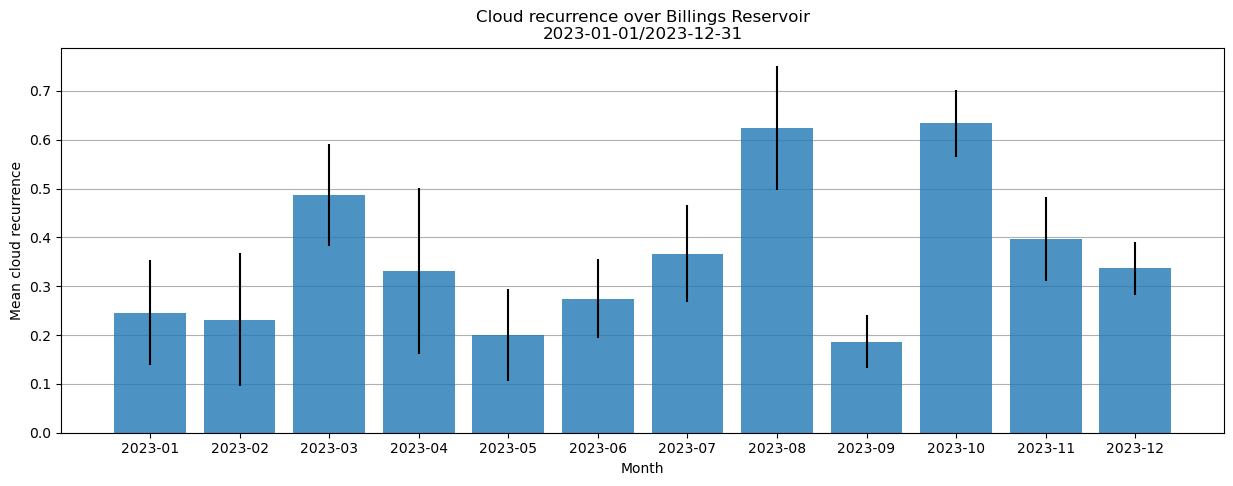

In [40]:
if monthly == 'y':

    plt.rc('axes', axisbelow=True);
    # Initialize variables
    date = list(final_vrts.keys())
    cloud_mean = []
    cloud_sd = []

    # Iterate over rasters
    for key in final_vrts.keys():

        # Get mean
        cloud_mean.append(np.nanmean(final_vrts[key]))

        # Get SD
        cloud_sd.append(np.nanstd(final_vrts[key]))

    # Create dataframe
    monthly_df = pd.DataFrame({'date':date, 'average':cloud_mean, 'sd':cloud_sd})

    # Sort values
    monthly_df_sorted = monthly_df.sort_values(by='average')

    # Get max
    max_month = monthly_df_sorted.date.iloc[-1]
    max_value = monthly_df_sorted.average.iloc[-1]
    max_sd = monthly_df_sorted.sd.iloc[-1]

    # Get min
    min_month = monthly_df_sorted.date.iloc[0]
    min_value = monthly_df_sorted.average.iloc[0]
    min_sd = monthly_df_sorted.sd.iloc[0]

    # Inform
    print(f'Basic statistics for the period {period}:')
    print(f'\nMonth with highest mean recurrence: {max_month} ({max_value:.2f} ± {max_sd:.2f})')
    print(f'Month with lowest mean recurrence: {min_month} ({min_value:.2f} ± {min_sd:.2f})\n')
    
    # Create figure
    plt.figure(figsize=(15, 5))

    # Plot SD values
    plt.errorbar(data=monthly_df, x='date', y='average', yerr='sd', color='black',
                linestyle='none', lolims=0)

    # Barplot
    plt.bar(data=monthly_df, x='date', height='average', alpha=0.8)

    # Details
    plt.xlabel('Month');
    plt.ylabel('Mean cloud recurrence');
    plt.grid(axis='y');

    if roi_type == 'mu':

        plt.title(f'Cloud recurrence over {roi_name} - {uf_name}\n{period}');

    else:

        plt.title(f'Cloud recurrence over {roi_name}\n{period}');

else:

    print('Monthly analysis has not been required or is not suitable')

**Monthly Maps:**

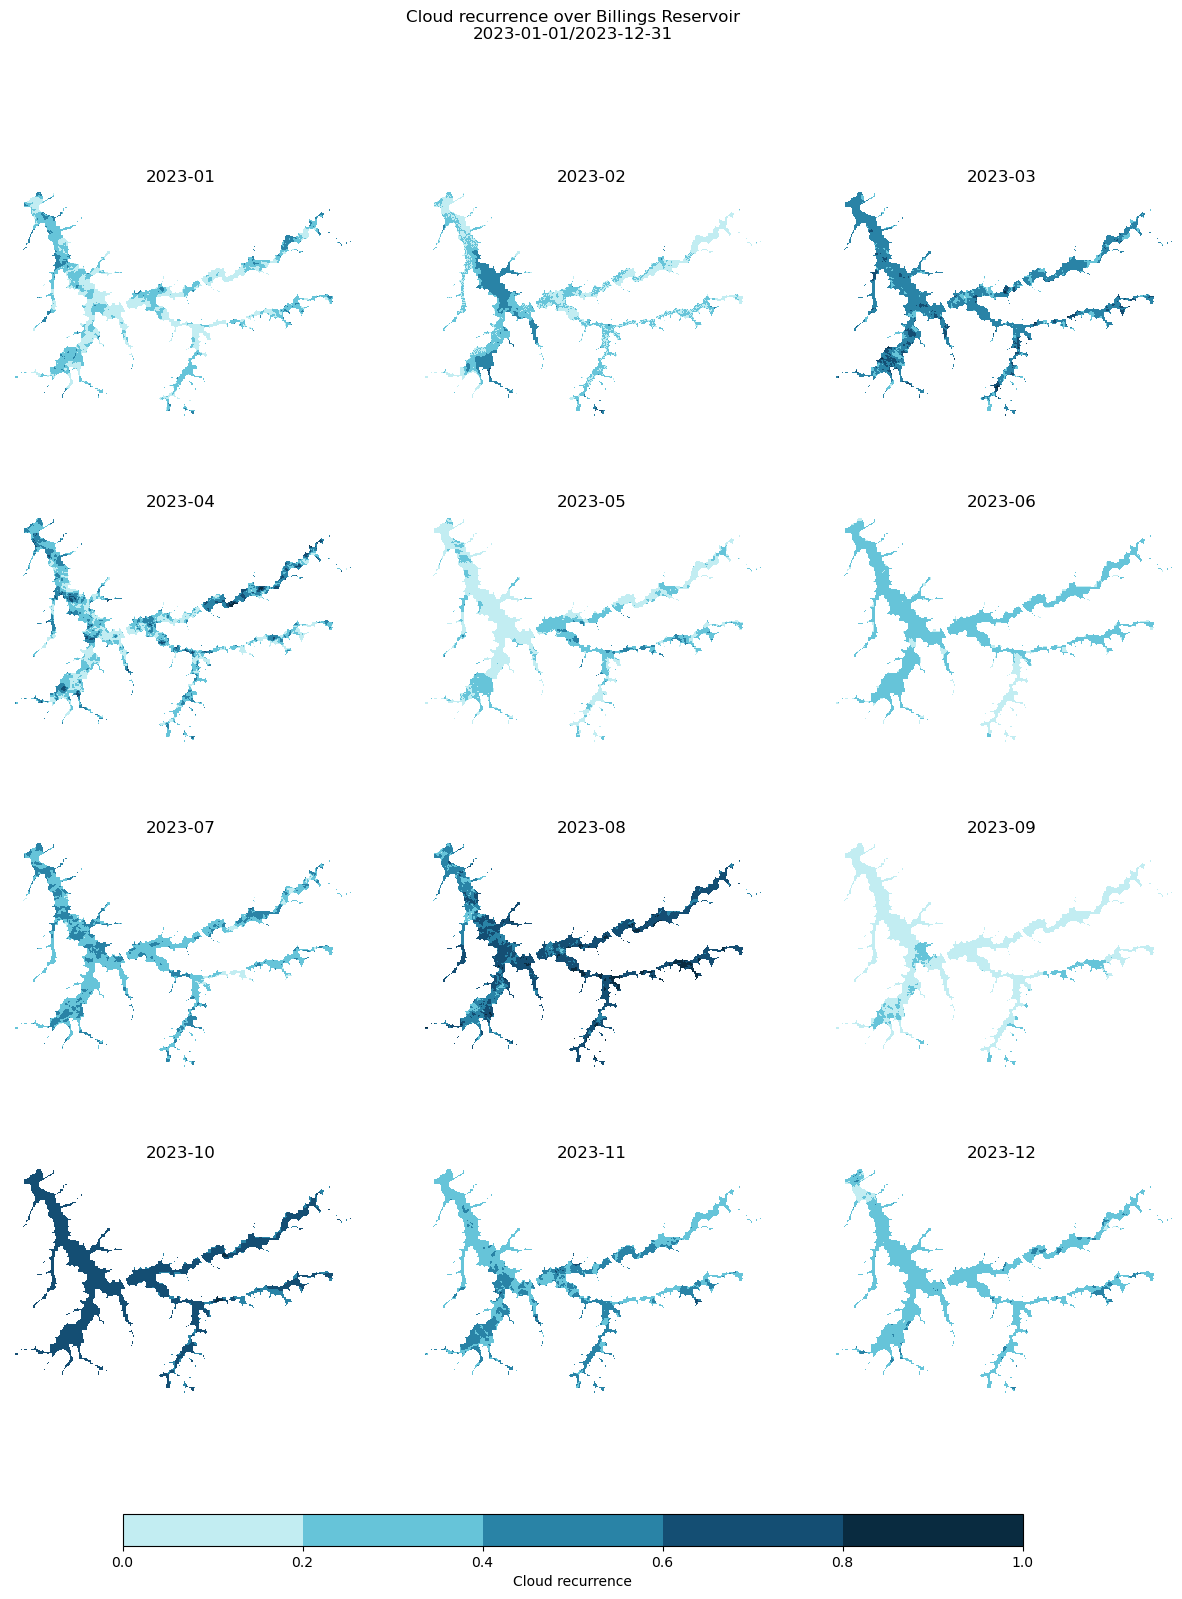

In [41]:
if monthly == 'y':

    # Number of plots
    ncol = int(3)
    nrow = int(np.ceil(len(final_vrts) / ncol))

    # Colors
    colors = ['#C2EDF2', '#66C4D9', '#2983A6', '#144E73', '#092B40']
    cmap = ListedColormap(colors)

    # Create figure
    fig = plt.figure(figsize=(15, nrow * 4))

    if roi_type == 'mu':

        plt.suptitle(f'Cloud recurrence over {roi_name} - {uf_name}');

    else:

        plt.suptitle(f'Cloud recurrence over {roi_name}\n{period}');

    # Iterate over each month
    for i in range(0, len(final_vrts)):

        # Set subplot
        plt.subplot(nrow, ncol, i + 1)

        # Plot image
        plot = plt.imshow(list(final_vrts.values())[i], cmap=cmap,
                          vmin=0, vmax=1)

        # Details
        plt.title(list(final_vrts.keys())[i])
        plt.xticks([])
        plt.yticks([])
        plt.box([])

    # Add legend
    fig.subplots_adjust(bottom=0.10)
    cbar_ax = fig.add_axes([0.2, 0.02, 0.6, 0.02], )
    fig.colorbar(plot, orientation='horizontal', cax=cbar_ax, label='Cloud recurrence')

else:

    print('Monthly analysis has not been required or is not suitable')

#### **Overall analysis**

If you required the development of an overall analysis, the following cells will provide information to the selected period.

In [42]:
if monthly != 'y' or overall == 'y':

    # Get the start time
    st = time.time()

    print('Start processing...\n')
    
    # Obtain data
    final_array = cloud_analysis(images=images, tiles=tiles)

    # get the end time
    et = time.time()
    
    # get the execution time
    elapsed_time = et - st
    
    print(f'\nProcessing finished ({elapsed_time:.2f} seconds)')

    # Convert to array and get statistics
    mean = np.nanmean(final_array)
    sd = np.nanstd(final_array)

    print(f'\nCloud cover recurrence in the period {period}:')
    print(f'Mean: {mean:.2f}')
    print(f'SD: {sd:.2f}')

else:

    print('Overall anlysis has not been required')

Start processing...

Tile 23KLP has 73 useful scenes and 74 discarded scenes
A total of 73 scenes were used and 74 were discarded

Processing finished (117.22 seconds)

Cloud cover recurrence in the period 2023-01-01/2023-12-31:
Mean: 0.36
SD: 0.03


**Overall Map:**

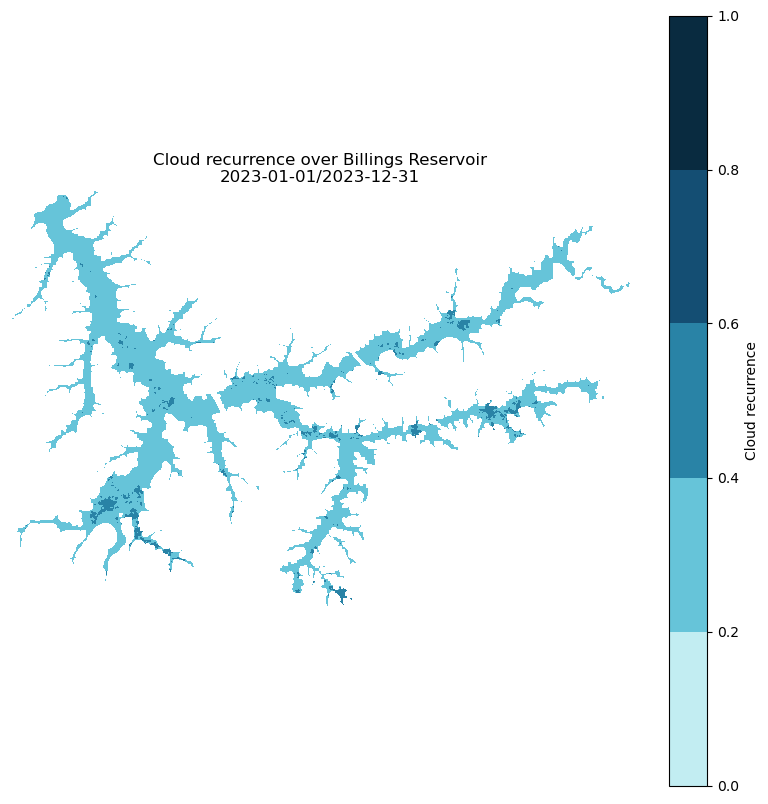

In [43]:
if monthly != 'y' or overall == 'y':

    # Colors
    colors = ['#C2EDF2', '#66C4D9', '#2983A6', '#144E73', '#092B40']
    cmap = ListedColormap(colors)

    # Create figure
    fig = plt.figure(figsize=(10, 10))

    # Plot image
    plot = plt.imshow(final_array, cmap=cmap, vmin=0, vmax=1);

    # Details
    plt.xticks([]);
    plt.yticks([]);
    plt.box([]);

    # Add legend
    fig.colorbar(plot, label='Cloud recurrence')
    
    if roi_type == 'mu':

        plt.title(f'\nCloud recurrence over {roi_name} - {uf_name}\n{period}');

    else:

        plt.title(f'\nCloud recurrence over {roi_name}\n{period}');

else:

    print('Overall anlysis has not been required')